# Design
###### Created by [Roberto Mora](https://github.com/romogo17)

I will be structuring the `pgcv` datatypes and functions in different PostgreSQL schemas. This schemas will group the operations logically. The structure is somewhat base on OpenCV.

The schemas will be:
1. `pgcv_core`
1. `pgcv_io`
1. `pgcv_filter`
1. `pgcv_histogram`
1. `pgcv_measure`
1. `pgcv_bundle`
1. `pgcv_draw` _(not yet implemented)_




## `pgcv_core`

This schema contains the datatypes used in the `pgcv` extension. These datatypes are basically a representation of a N-dimension array in PostgreSQL. The idea is to map the `numpy.ndarray` to theese structures.

The `regionprops` data type is used to to store information about the properties of the segmented labeled image. This allows the user to query specific features of the object found in the image.

```SQL
CREATE TYPE pgcv_core.ndarray_int4 AS (
  shape   int[],
  data    int[]
);

CREATE TYPE pgcv_core.regionprops AS (
  label         int,
  area          int,
  perimeter     float,
  centroid      float[2],
  solidity      float,
  eccentricity  float,
  convex_area   int,
  circularity   float,
  orientation   float,
  bbox          int[4]
);
```

On the other hand, there are some functions that were incorporated into the core of the extension. For instance `hash_avg` calculates the average hash of an image

```SQL
CREATE OR REPLACE FUNCTION pgcv_core.hash_avg(image pgcv_core.ndarray_int4, size int DEFAULT 8)
  RETURNS varchar
```

---
These functions can be called with the following code

```SQL
-- having an image in the database (size defaults to 8)
SELECT pgcv_core.hash_avg(<image>, [<size>]);

-- having an image in the database, 
-- and the size of the thumbnail (size defaulta to 200x200)
SELECT pgcv_core.thumbnail(<image>, [<width>, [<height>]])

-- having an image in the database, 
-- and the size of the thumbnail (size defaulta to 200x200)
SELECT pgcv_core.thumbnail_uri_base64(<image>, [<width>, [<height>]])

-- having an image in the database
SELECT pgcv_core.uri_base64(<image>)
```


Thumbnail of size 200x200


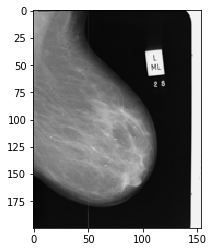

In [6]:
import numpy as np
import matplotlib.pyplot as plt 
from PIL import Image

filename = 'data/mdb147lx'

'''
With the extension
'''
# img = np.array(image["data"]).reshape(image["shape"]).astype('uint8')
# img = Image.fromarray(img)

'''
With a file
'''
size = 200, 200
img = Image.open(filename + '.png')

'''
Create a thumbnail for the image
'''
img.thumbnail(size)
img.save(filename + ".thumbnail.jpg", "JPEG")
plt.imshow(img, cmap = plt.get_cmap('gray'))
print("Thumbnail of size 200x200")

# '''
# Convert the image to base64 data URI
# '''
# import base64
# from io import BytesIO

# buffered = BytesIO()
# img.save(buffered, format="PNG")
# img_str = base64.b64encode(buffered.getvalue())

# print('data:image/png;base64,' + img_str.decode("utf-8"))


## `pgcv_io`

This schema contains the image input and output functions to the filesystem. Meaning that this functions read and write images into files.

```SQL
CREATE OR REPLACE FUNCTION pgcv_io.image_read(filename varchar)
  RETURNS pgcv_core.ndarray_int4

CREATE OR REPLACE FUNCTION pgcv_io.image_write(image pgcv_core.ndarray_int4, filename varchar)
  RETURNS boolean
```
---
These functions can be tested with the following code

```SQL
-- having a filename that represents an image
SELECT shape FROM pgcv_io.image_read('<filename>');

-- having an image in the database and the output filename
SELECT pgcv_io.image_write(<image>, '<filename>');
```

## `pgcv_filtering`

This schema contains the image filtering functions. One example of this functions is the `median_blur` which replaces each pixel by the median of a local window array given by a kernel size.

```SQL
CREATE OR REPLACE FUNCTION pgcv_filter.blur_median(image pgcv_core.ndarray_int4, kernel int DEFAULT 3)
  RETURNS pgcv_core.ndarray_int4
  
CREATE OR REPLACE FUNCTION pgcv_filter.threshold_otsu(image pgcv_core.ndarray_int4)
  RETURNS float
```

The next function uses a method designed by **Johnny Villalobos** that has proven to be quite effective for mammogram segmentation. It is described follows:

Let $t$ be the _threshold_ of an image calculated through the Otsu's method and $f$ the enhancement factor so that

$$f = \frac{t}{255 - t}$$

the value of each enhanced pixel $p'$ corresponds to

\begin{equation}
\begin{split}
p'  &= (255 - p (1 + f)) - f(255 - p (1 + f)) \\
    &= (1 - f) (255 - p (1 + f))
\end{split}
\end{equation}


```SQL
CREATE OR REPLACE FUNCTION pgcv_filter.enhancement_otsu(image pgcv_core.ndarray_int4)
  RETURNS pgcv_core.ndarray_int4
  
CREATE OR REPLACE FUNCTION pgcv_filter.binarize(image pgcv_core.ndarray_int4, thresh float)
  RETURNS pgcv_core.ndarray_int4
```
---
These functions can be tested with the following code

```SQL
-- having an image in the database and odd kernel size (kernel size defaults to 5 if not specified)
SELECT pgcv_filter.median_blur(<image>, [<kernel size>]);

-- having an image in the database
SELECT pgcv_filter.threshold_otsu(<image>);

-- having an image in the database
SELECT pgcv_filter.enhancement_otsu(<image>);

-- having an image in the database and a threshold value
SELECT pgcv_filter.binarize(<image>, <threshold>);
```


## `pgcv_histogram`

This schema contains the histogram computing functions. There are two main kinds of histograms in `pgcv`, both return an histogram and a set of bin features (either the center of the bins or the edges)

```SQL
CREATE OR REPLACE FUNCTION pgcv_histogram.hist_bin_edges(image pgcv_core.ndarray_int4, bins int DEFAULT 10, as_float boolean DEFAULT TRUE,
  OUT hist numeric[], OUT bin_edges numeric[])
  
CREATE OR REPLACE FUNCTION pgcv_histogram.hist_bin_centers(image pgcv_core.ndarray_int4, bins int DEFAULT 10,
  OUT hist numeric[], OUT bin_centers numeric[])
```

---
These functions can be tested with the following code

```SQL
-- having an image in the database, the number of bins (bins defaults to 10 if not specified) and whether the histogram has to be normalized or not
SELECT * FROM pgcv_histogram.hist_bin_edges(<image>, [<bins>, [<as_float>]]);

-- having an image in the database and the number of bins (bins defaults to 10 if not specified) 
SELECT * FROM pgcv_histogram.hist_bin_centers(<image>, [<bins>]);
```


## `pgcv_measure`

This schema contains the functions that perform measure computations on the image. In particular, `pgcv_measure` includes de region properties functions, which find objects on a binarize image

```SQL
CREATE OR REPLACE FUNCTION pgcv_measure.region_props_json(image pgcv_core.ndarray_int4)
  RETURNS jsonb
  
CREATE OR REPLACE FUNCTION pgcv_measure.region_props(image pgcv_core.ndarray_int4)
  RETURNS SETOF pgcv_core.regionprops
```

---
These functions can be tested with the following code

```SQL
-- having a binarized image in the database
SELECT pgcv_measure.region_props_json(<image>);

-- having a binarized image in the database
-- this allows for the inclusion of WHERE conditions
-- for filter the properties
SELECT * FROM pgcv_measure.region_props(<image>);
```

## `pgcv_bundle`

The bundle schema provides access to common successive operations performed to an image. The purpose of this schema is to reduce the overhead produced by the comunication from the PostgreSQL server and Python.


This functions operate on unaltered images, meaning, images in the PostgreSQL server but not yet processed.

```SQL
CREATE OR REPLACE FUNCTION pgcv_bundle.mam_region_props(image pgcv_core.ndarray_int4, kernel int DEFAULT 5)
  RETURNS SETOF pgcv_core.regionprops
```

---

These functions can be tested with the following code

```SQL
-- having an image in the database and odd kernel size (kernel size defaults to 5 if not specified)
SELECT * FROM pgcv_bundle.mam_region_props(<image>, [<kernel size>]);
```

In [2]:
from PIL import Image
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from scipy import signal
from skimage import measure, filters
import json

img = Image.open('./data/mdb155.pgm')
#img = Image.open('/Users/ro/Desktop/prueba.png')
img = np.array(img).astype('uint8')


"""
1. Apply the mean filter
"""
img = signal.medfilt(img, 5).astype('uint8')

"""
2. Enhance the image through the otsu enhancement
"""
thresh = filters.threshold_otsu(img)
f = thresh / (255 - thresh)
img = ((1 - f) * (255 - img * (1 + f))).astype('uint8')

"""
3. Binarize the image
"""
img = np.where(img < thresh, 0, 255)

"""
4. Calculate the regionprops
"""
# Get the regionprops
lbl = measure.label(img)
regions = measure.regionprops(lbl, coordinates='rc')

# Initialize the DataFrame with the desired columns
columns = [('label', int),
           ('area', int),
           ('perimeter', float),
           ('centroid', object),
           ('solidity', float),
           ('eccentricity', float),
           ('convex_area', int),
           ('circularity', float),
           ('orientation', float),
           ('bbox', object)]
df = pd.DataFrame({k: pd.Series(dtype=t) for k, t in columns})

# Fill the DataFrame
for i, reg in enumerate(regions):
    df.loc[i] = [
        reg.label,
        reg.area,
        reg.perimeter,
        reg.centroid,
        reg.solidity,
        reg.eccentricity,
        reg.convex_area,
        4 * np.pi * reg.area / reg.perimeter ** 2 if reg.perimeter != 0 else np.inf,  # circularity
        reg.orientation,
        reg.bbox
    ]
    
# result = df.to_json(orient='records', double_precision=4)
# print(result)
    
display(df)

# plt.figure(figsize=(11, 11))
# plt.imshow(img, cmap = plt.get_cmap('gray'))


,label,area,perimeter,centroid,solidity,eccentricity,convex_area,circularity,orientation,bbox
0,1,593891,6379.937300,"(444.15259197394806, 454.06933932320914)",0.566379,0.519865,1048576,0.183351,-1.535771,"(0, 0, 1024, 1024)"
1,2,16264,709.646753,"(112.46593703885883, 793.8274717166748)",0.922937,0.913972,17622,0.405838,-0.294397,"(28, 710, 280, 837)"
2,3,49,31.727922,"(286.9387755102041, 833.1020408163265)",0.720588,0.773579,68,0.611678,-0.320758,"(283, 829, 295, 837)"
3,4,12,10.035534,"(299.25, 833.4166666666666)",0.923077,0.855502,13,1.497305,0.685730,"(297, 832, 302, 836)"
4,5,10,8.828427,"(420.2, 427.5)",1.000000,0.683130,10,1.612290,-1.570796,"(419, 426, 422, 430)"
5,6,229,94.911688,"(427.4017467248908, 446.3930131004367)",0.620596,0.796357,369,0.319452,1.566909,"(421, 431, 440, 462)"
6,7,29,17.071068,"(473.6551724137931, 481.2758620689655)",0.966667,0.516245,30,1.250508,-0.618715,"(471, 479, 477, 485)"
7,8,101,50.870058,"(478.5742574257426, 504.05940594059405)",0.801587,0.961610,126,0.490464,-1.322596,"(475, 494, 484, 516)"
8,9,8,8.414214,"(490.5, 461.125)",0.888889,0.937309,9,1.419949,-1.456334,"(490, 459, 492, 464)"
9,10,3853,396.818326,"(543.431871269141, 440.0153127433169)",0.724520,0.716600,5318,0.307486,1.427281,"(503, 385, 583, 489)"
